In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [ ]:
Company = input("Ticker of the Stock:")
Date1 = input("Start(YYYY-MM-DD):")
Date2 = input("End(YYYY-MM-DD):")

Ticker of the Stock:TCS.NS
Start(YYYY-MM-DD):2010-01-01
End(YYYY-MM-DD):2023-01-01


In [ ]:
Data = yf.download(Company,Date1, Date2)
Data =Data.reset_index()
Data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,377.399994,379.450012,374.524994,375.825012,286.916779,1963682
1,2010-01-05,377.500000,379.774994,373.274994,375.924988,286.993042,2014488
2,2010-01-06,375.924988,376.100006,366.500000,367.424988,280.503876,3349176
3,2010-01-07,367.750000,369.700012,355.500000,357.200012,272.697754,6474892
4,2010-01-08,358.000000,359.250000,348.250000,349.899994,267.124725,6048178
...,...,...,...,...,...,...,...
3204,2022-12-26,3228.350098,3272.000000,3225.050049,3252.899902,3156.570068,870157
3205,2022-12-27,3269.199951,3273.800049,3231.500000,3259.500000,3162.974854,835883
3206,2022-12-28,3249.800049,3266.100098,3226.000000,3257.100098,3160.645996,910795
3207,2022-12-29,3231.100098,3271.500000,3228.000000,3268.750000,3171.950928,1037927


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3209 entries, 0 to 3208
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3209 non-null   datetime64[ns]
 1   Open       3209 non-null   float64       
 2   High       3209 non-null   float64       
 3   Low        3209 non-null   float64       
 4   Close      3209 non-null   float64       
 5   Adj Close  3209 non-null   float64       
 6   Volume     3209 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 175.6 KB


In [ ]:
Data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Data Visualization

### Stock Price

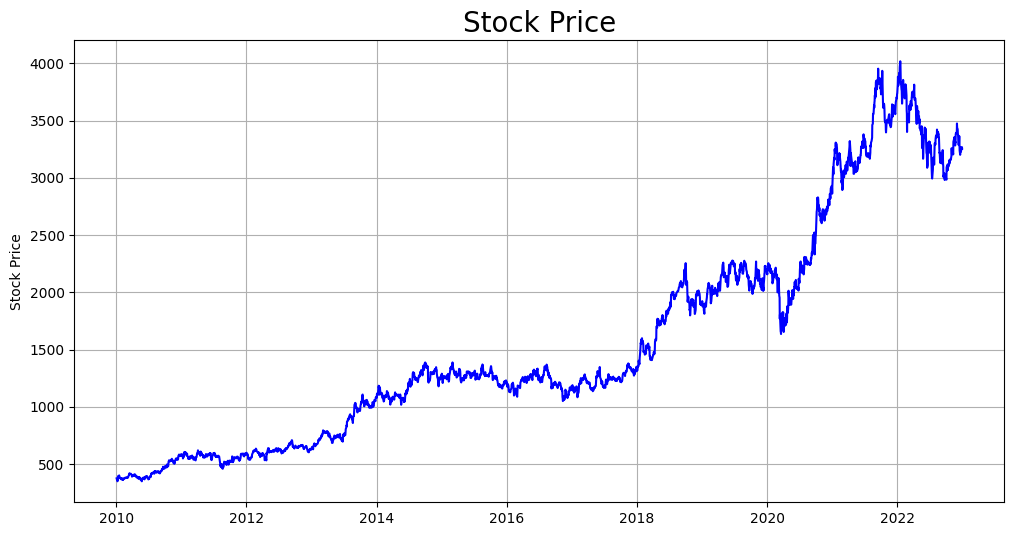

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Stock Price", fontsize="20")
ax.plot(Data["Date"], Data["Close"], color="Blue")
ax.set_ylabel("Stock Price")
plt.grid()
plt.show()

### Moving Average


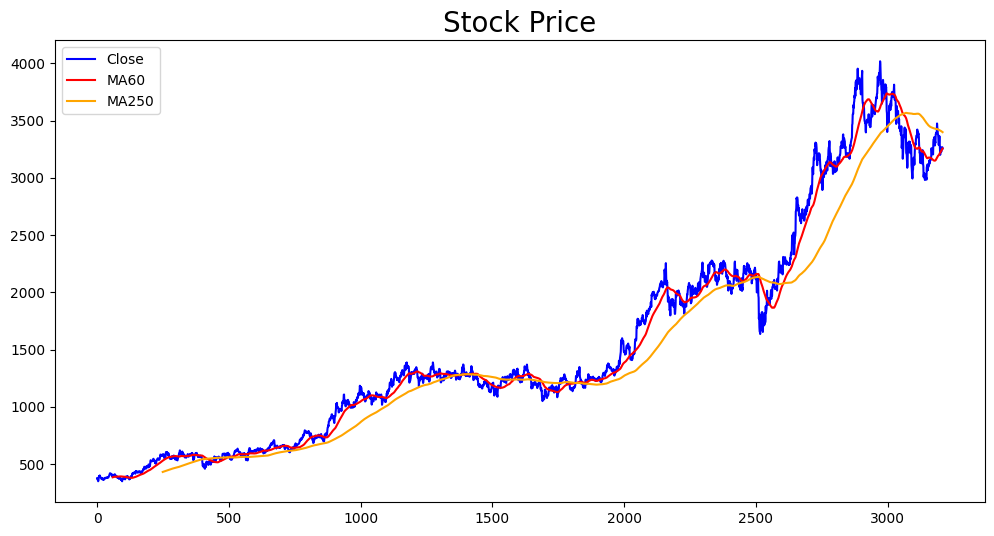

In [ ]:
MA60=Data.Close.rolling(60).mean()
MA250=Data.Close.rolling(250).mean()
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Stock Price",fontsize= 20)
plt.plot(Data.Close, color="Blue", label="Close")
plt.plot(MA60, color = 'Red', label = "MA60")
plt.plot(MA250, color = 'Orange', label = "MA250")
plt.legend()

### Volume

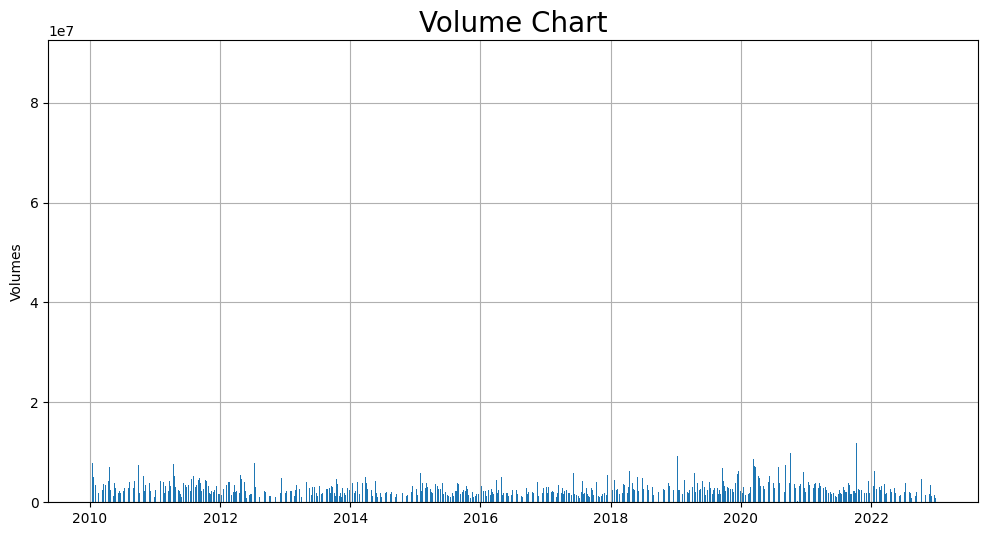

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Volume Chart", fontsize="20")
ax.bar(Data["Date"], Data["Volume"])
ax.set_ylabel("Volumes")
plt.grid()
plt.show()

### Daily Return

In [ ]:
Data["Daily Return"] = Data["Close"].pct_change(1)
Data["Daily Return"]

0            NaN
1       0.000266
2      -0.022611
3      -0.027829
4      -0.020437
          ...   
3204    0.007604
3205    0.002029
3206   -0.000736
3207    0.003577
3208   -0.003686
Name: Daily Return, Length: 3209, dtype: float64

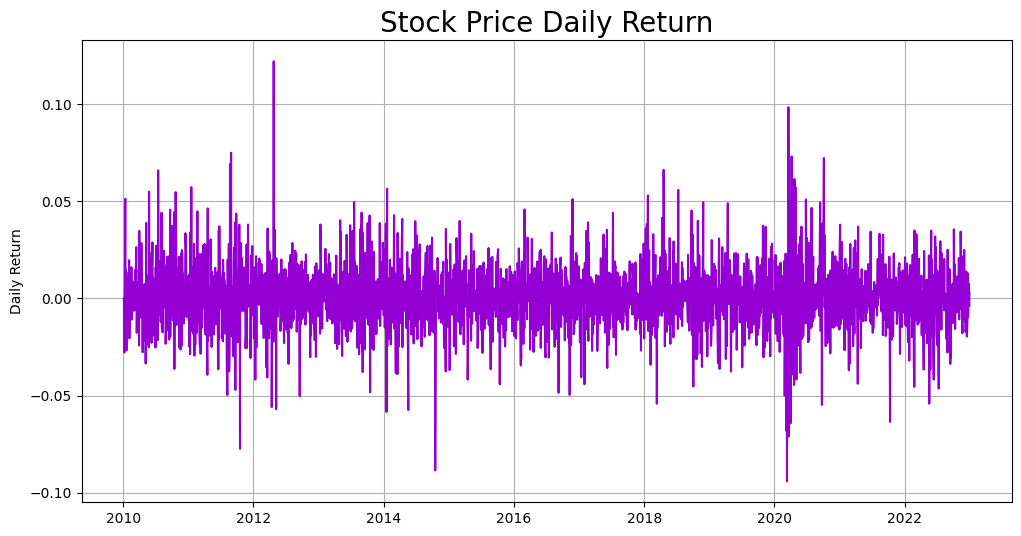

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
plt.title("Stock Price Daily Return",fontsize="20")
ax.plot(Data["Date"], Data["Daily Return"], color="Darkviolet")
ax.set_ylabel("Daily Return")
plt.grid()
plt.show()

<Axes: >

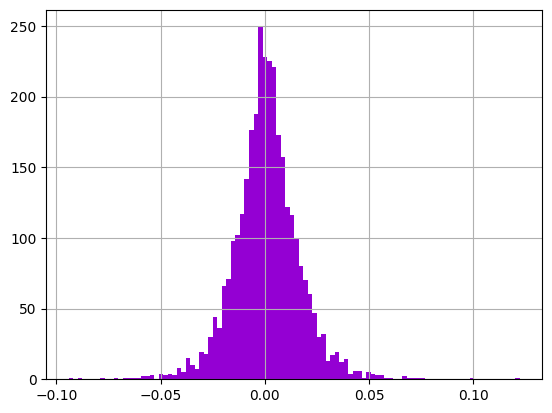

In [ ]:
#Distribution of Daily Return(Volatility)
Data.iloc[Data["Daily Return"].argmax()]
Data["Daily Return"].hist(bins=100, color='Darkviolet')

### Cumulative Return

In [ ]:
Data["Cumulative Return"] = (1+Data["Daily Return"]).cumprod()
Data["Cumulative Return"]

0            NaN
1       1.000266
2       0.977649
3       0.950442
4       0.931018
          ...   
3204    8.655358
3205    8.672919
3206    8.666534
3207    8.697532
3208    8.665469
Name: Cumulative Return, Length: 3209, dtype: float64

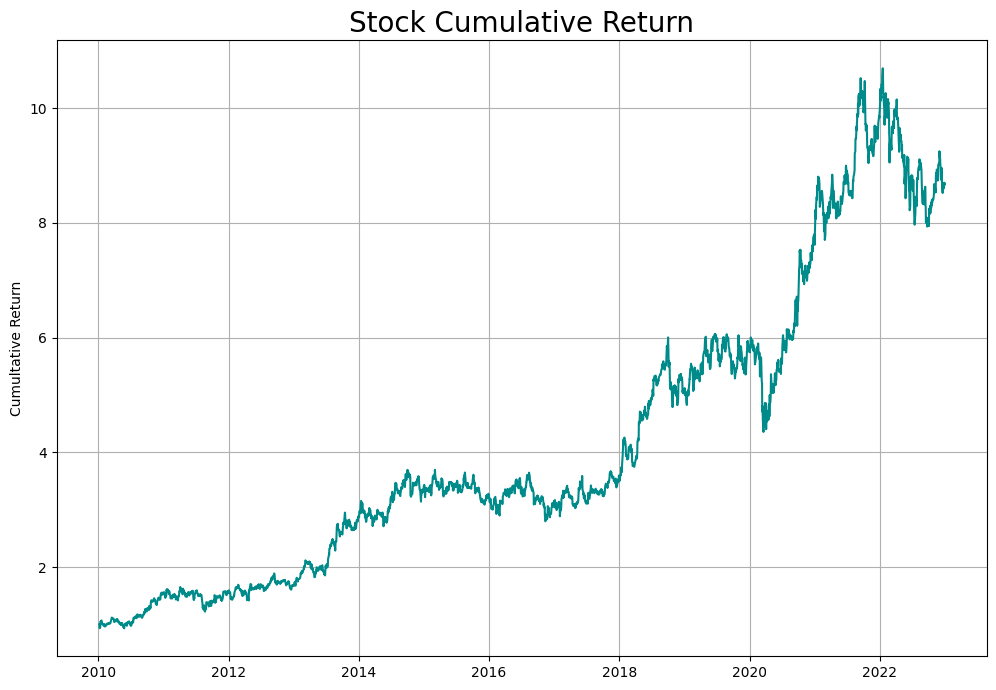

In [ ]:
#Cumulative Return of the stock during the given period
fig, ax = plt.subplots(figsize=(12,8))
plt.title("Stock Cumulative Return",fontsize="20")
ax.plot(Data["Date"], Data["Cumulative Return"], color="Darkcyan")
ax.set_ylabel("Cumultative Return")
plt.grid()
plt.show()

## Data Preprocessing

### Splitting Data into Training and Validation Sets

In [ ]:
Data['Date'] = pd.to_datetime(Data['Date'])
Data.set_index('Date',inplace=True)
Close = Data.filter(['Close'])
CloseValue = Close.values
TrainingDataLength = math.ceil(len(CloseValue)*.8)
TrainingDataLength

2568

###  Scaling Data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
PriceData = scaler.fit_transform(CloseValue)
PriceData
## Customized the function:
# def Rank(data):
#     feature_range = data.max() - data.min()
#     scaled_data = (data - data.min()) / feature_range
#     return scaled_data
# PriceData = Rank(CloseValue)
# Rank(CloseValue)

array([[0.00709931],
       [0.00712655],
       [0.00481008],
       ...,
       [0.79232163],
       [0.79549653],
       [0.79221258]])

### Creating Sequences

In [ ]:
X_train, Y_train = [],[]
Backcandles = 60
TrainData = PriceData[0:TrainingDataLength]
for i in range(Backcandles,len(TrainData)):
    X_train.append(TrainData[i-Backcandles:i, 0])
    Y_train.append(TrainData[i,0])
    if i<= Backcandles:
        print("X_train:",X_train,"\nY_train:",Y_train)
X_train,Y_train = np.array(X_train), np.array(Y_train)

X_train: [array([7.09930682e-03, 7.12655276e-03, 4.81008192e-03, 2.02351041e-03,
       3.40657477e-05, 1.99625614e-03, 6.88128104e-03, 1.21274062e-02,
       1.09419165e-02, 1.25157607e-02, 1.39873993e-02, 1.10577450e-02,
       1.08806048e-02, 9.68830365e-03, 7.94413071e-03, 7.71930176e-03,
       5.96150585e-03, 5.75029988e-03, 4.99404195e-03, 6.34986037e-03,
       5.29382219e-03, 7.27644704e-03, 5.33469942e-03, 3.26350030e-03,
       3.35207457e-03, 4.85096747e-03, 4.46261295e-03, 5.87975139e-03,
       6.34986037e-03, 7.98501626e-03, 8.05314776e-03, 8.07358221e-03,
       6.94941254e-03, 7.86237624e-03, 8.52324842e-03, 8.96610314e-03,
       9.08874316e-03, 8.48237119e-03, 8.67314270e-03, 9.42940064e-03,
       8.76852846e-03, 8.59137992e-03, 8.60501121e-03, 9.42258915e-03,
       1.09691708e-02, 1.25430067e-02, 1.32720186e-02, 1.61403529e-02,
       1.76392458e-02, 1.92335245e-02, 1.72100141e-02, 1.65355189e-02,
       1.74484743e-02, 1.75915571e-02, 1.77482546e-02, 1.71010054e-

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape

(2508, 60, 1)

## LSTM Model Building, Compiling, and Training

In [ ]:
Model = Sequential([
    LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    (Dropout(0.2)),
    LSTM((50)),
    (Dropout(0.2)),
    (Dense(32)),
    (Dense(1))
])

Model.compile(optimizer="adam", loss="mean_squared_error")
Model.fit(X_train, Y_train, batch_size=32, epochs=10)
Model.summary()

Epoch 1/10
79/79 [==============================] - 12s 92ms/step - loss: 0.0045
Epoch 2/10
79/79 [==============================] - 5s 66ms/step - loss: 7.7280e-04
Epoch 3/10
79/79 [==============================] - 6s 82ms/step - loss: 5.6154e-04
Epoch 4/10
79/79 [==============================] - 5s 65ms/step - loss: 4.8520e-04
Epoch 5/10
79/79 [==============================] - 5s 66ms/step - loss: 4.1550e-04
Epoch 6/10
79/79 [==============================] - 6s 79ms/step - loss: 4.0930e-04
Epoch 7/10
79/79 [==============================] - 5s 65ms/step - loss: 3.9119e-04
Epoch 8/10
79/79 [==============================] - 6s 81ms/step - loss: 3.3290e-04
Epoch 9/10
79/79 [==============================] - 5s 65ms/step - loss: 3.4016e-04
Epoch 10/10
79/79 [==============================] - 6s 71ms/step - loss: 3.2050e-04
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 

In [ ]:
test_data= PriceData[TrainingDataLength-Backcandles:, :]
x_test, y_test = [], CloseValue[TrainingDataLength:,:]
for i in range(Backcandles,len(test_data)):
    x_test.append(test_data[i-Backcandles:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(641, 60, 1)

## Results of the Prediction

### Root-Mean-Square Error
&emsp;&emsp;A higher RMSE value generally indicates poorer predictive performance. Hence, our training objective is to "minimize RMSE".

In [ ]:
Pred = Model.predict(x_test)
Pred = scaler.inverse_transform(Pred)
RMSE = np.sqrt(np.mean(Pred - y_test)**2)
RMSE


21/21 [==============================] - 1s 16ms/step


106.77777604268233

### Prediction Results

In [ ]:
TrainingSet,ValidationSet = Close[:TrainingDataLength],Close[TrainingDataLength:]
ValidationSet["Predictions"] = Pred
ValidationSet


,Close,Predictions
Date,,
2020-06-09,2072.050049,2008.057007
2020-06-10,2108.750000,2016.563110
2020-06-11,2067.649902,2026.163086
2020-06-12,2039.500000,2033.527466
2020-06-15,2029.900024,2037.387573
...,...,...
2022-12-26,3252.899902,3173.970947
2022-12-27,3259.500000,3166.584229
2022-12-28,3257.100098,3161.392822


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['Close'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['Predictions'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['Close'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['Predictions'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_4, *[[['Close', 'Predictions']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_5, *['Date', 'Close', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_6, *['Date', 'Predictions', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_7, *['Date', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_8, *['Date', 'Close', None], **{})
chart

### Visualization

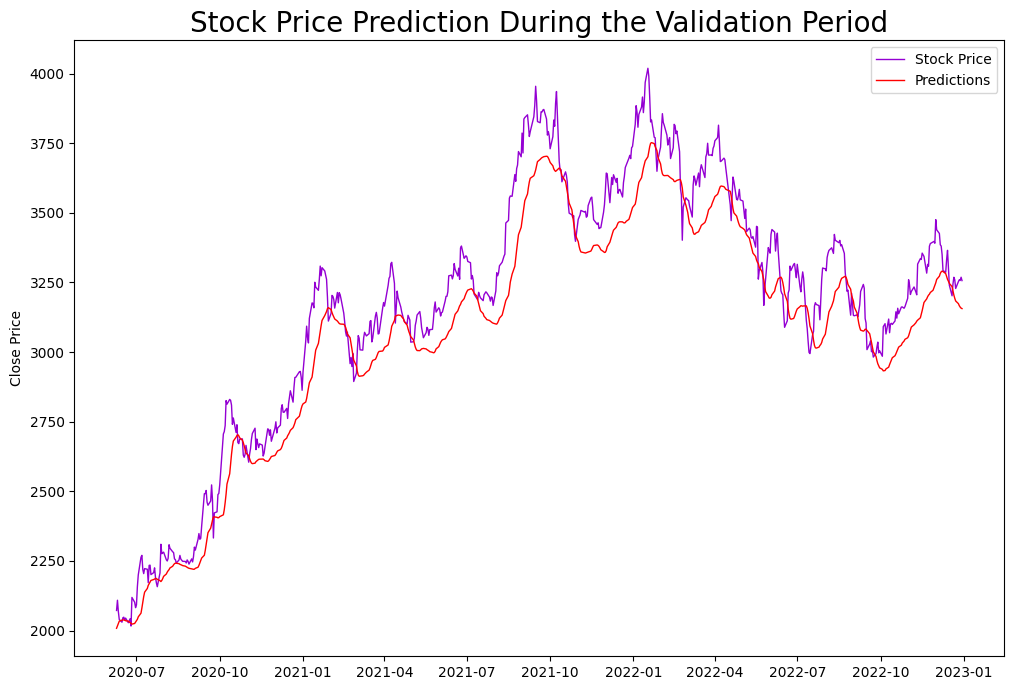

In [ ]:
plt.figure(figsize=(12,8))
plt.title("Stock Price Prediction During the Validation Period", fontsize = 20)
plt.ylabel("Close Price")
plt.plot(ValidationSet["Close"],linewidth=1,color = "Darkviolet")
plt.plot(ValidationSet["Predictions"],linewidth=1,color = "Red")
plt.legend(["Stock Price","Predictions"])

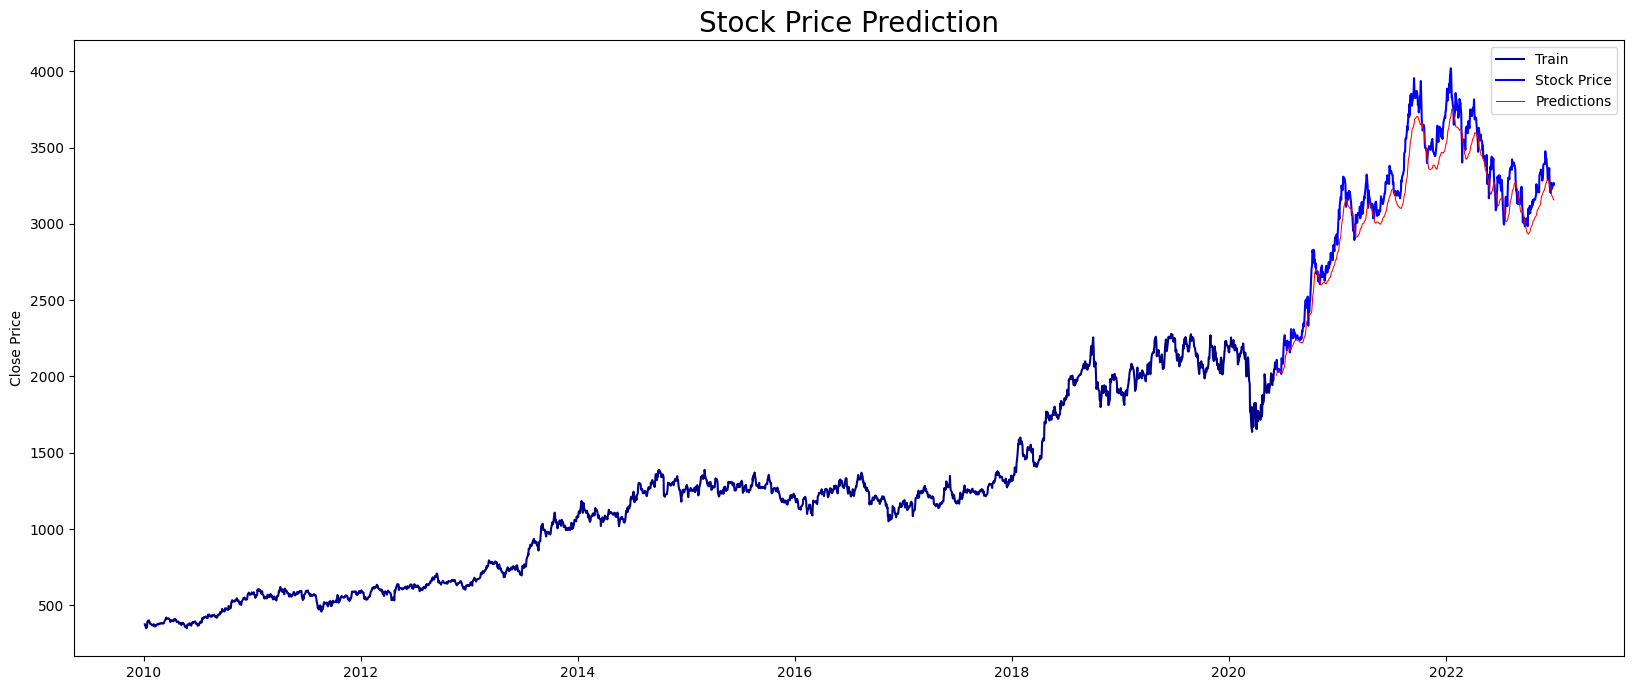

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Stock Price Prediction", fontsize=20)
plt.ylabel("Close Price" )
plt.plot(TrainingSet["Close"], color = "Darkblue")
plt.plot(ValidationSet["Close"],color = "Blue")
plt.plot(ValidationSet["Predictions"],linewidth=0.75,color = "Red")
plt.legend(["Train","Stock Price","Predictions"])

### &emsp;&emsp;Please note that using LSTM with raw stock price data is impractical and using min-max scaler to scale the price data is also unreasonable, since the raw stock price data is neither stationarity nor extrapolation. You'll find out it doesn’t work in real-life (The prediction seems accurate because it's nothing but a delay curve :P).
### &emsp;&emsp;When utilizing LSTM for financial data prediction, forecasting "Log Return" might be a better option. This project is better suited as a programming example for basic machine learning rather than a precise stock price prediction.